### KNN (K-Nearest Neighbors Classification)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

# Seaborn is a nice package for plotting, but you have to use pip to install
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier

#### Load in the Wisconsin breast cancer dataset. The attributes below will be the columns of the dataset.

Attribute Information: (class attribute has been moved to last column)

      Attribute                     Values
   -- -----------------------------------------
   1. Sample code number            id number
   2. Clump Thickness               1 - 10
   3. Uniformity of Cell Size       1 - 10
   4. Uniformity of Cell Shape      1 - 10
   5. Marginal Adhesion             1 - 10
   6. Single Epithelial Cell Size   1 - 10
   7. Bare Nuclei                   1 - 10
   8. Bland Chromatin               1 - 10
   9. Normal Nucleoli               1 - 10
   10. Mitoses                       1 - 10
   11. Class:                        (2 for benign, 4 for malignant)

The column names are taken from the dataset info file. Create an array
with the column names and assign them as the header when loading the
csv.

In [1]:
column_names = ['id',
                'clump_thickness',
                'cell_size_uniformity',
                'cell_shape_uniformity',
                'marginal_adhesion',
                'single_epithelial_size',
                'bare_nuclei',
                'bland_chromatin',
                'normal_nucleoli',
                'mitoses',
                'class']

breast_cancer_data = pd.read_csv('../assets/datasets/breast-cancer-wisconsin.csv',
                                 na_values=['?'], # Drop the '?' NA values
                                 names=column_names)

# Drop the NA/null values as well
breast_cancer_data.dropna(inplace=True)
breast_cancer_data.head()

The class field is coded as "2" for benign and "4" as malignant. 
- Let's recode this to a binary variable for classification, with "1" as malign and "0" as benign.

In [5]:
breast_cancer_data['class'] = breast_cancer_data['class'].map(lambda x: 0 if x == 2 else 1)

Look at the data using seaborn's "pairplot" function. First put the dataset into "long" format, which seaborn requires for it's plotting functions:

In [11]:
breast_cancer_data_plot = breast_cancer_data[[x for x in breast_cancer_data.columns if x != 'id']]
breast_cancer_data_plot.head()

,clump_thickness,cell_size_uniformity,cell_shape_uniformity,marginal_adhesion,single_epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,5,1,1,1,2,1.0,3,1,1,0
1,5,4,4,5,7,10.0,3,2,1,0
2,3,1,1,1,2,2.0,3,1,1,0
3,6,8,8,1,3,4.0,3,7,1,0
4,4,1,1,3,2,1.0,3,1,1,0


It's very useful and recommended to look at the correlation matrix:

In [12]:
breast_cancer_data_plot.corr()

,clump_thickness,cell_size_uniformity,cell_shape_uniformity,marginal_adhesion,single_epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
clump_thickness,1.000000,0.642481,0.653470,0.487829,0.523596,0.593091,0.553742,0.534066,0.350957,0.714790
cell_size_uniformity,0.642481,1.000000,0.907228,0.706977,0.753544,0.691709,0.755559,0.719346,0.460755,0.820801
cell_shape_uniformity,0.653470,0.907228,1.000000,0.685948,0.722462,0.713878,0.735344,0.717963,0.441258,0.821891
marginal_adhesion,0.487829,0.706977,0.685948,1.000000,0.594548,0.670648,0.668567,0.603121,0.418898,0.706294
single_epithelial_size,0.523596,0.753544,0.722462,0.594548,1.000000,0.585716,0.618128,0.628926,0.480583,0.690958
bare_nuclei,0.593091,0.691709,0.713878,0.670648,0.585716,1.000000,0.680615,0.584280,0.339210,0.822696
bland_chromatin,0.553742,0.755559,0.735344,0.668567,0.618128,0.680615,1.000000,0.665602,0.346011,0.758228
normal_nucleoli,0.534066,0.719346,0.717963,0.603121,0.628926,0.584280,0.665602,1.000000,0.433757,0.718677
mitoses,0.350957,0.460755,0.441258,0.418898,0.480583,0.339210,0.346011,0.433757,1.000000,0.423448
class,0.714790,0.820801,0.821891,0.706294,0.690958,0.822696,0.758228,0.718677,0.423448,1.000000


Most of these predictors are highly correlated with the "class" variable. This is already an indication that our classifier is very likely to perform well.

We can plot out in detail how the classes distribute across the variables using the very useful pairplot() function from seaborn:

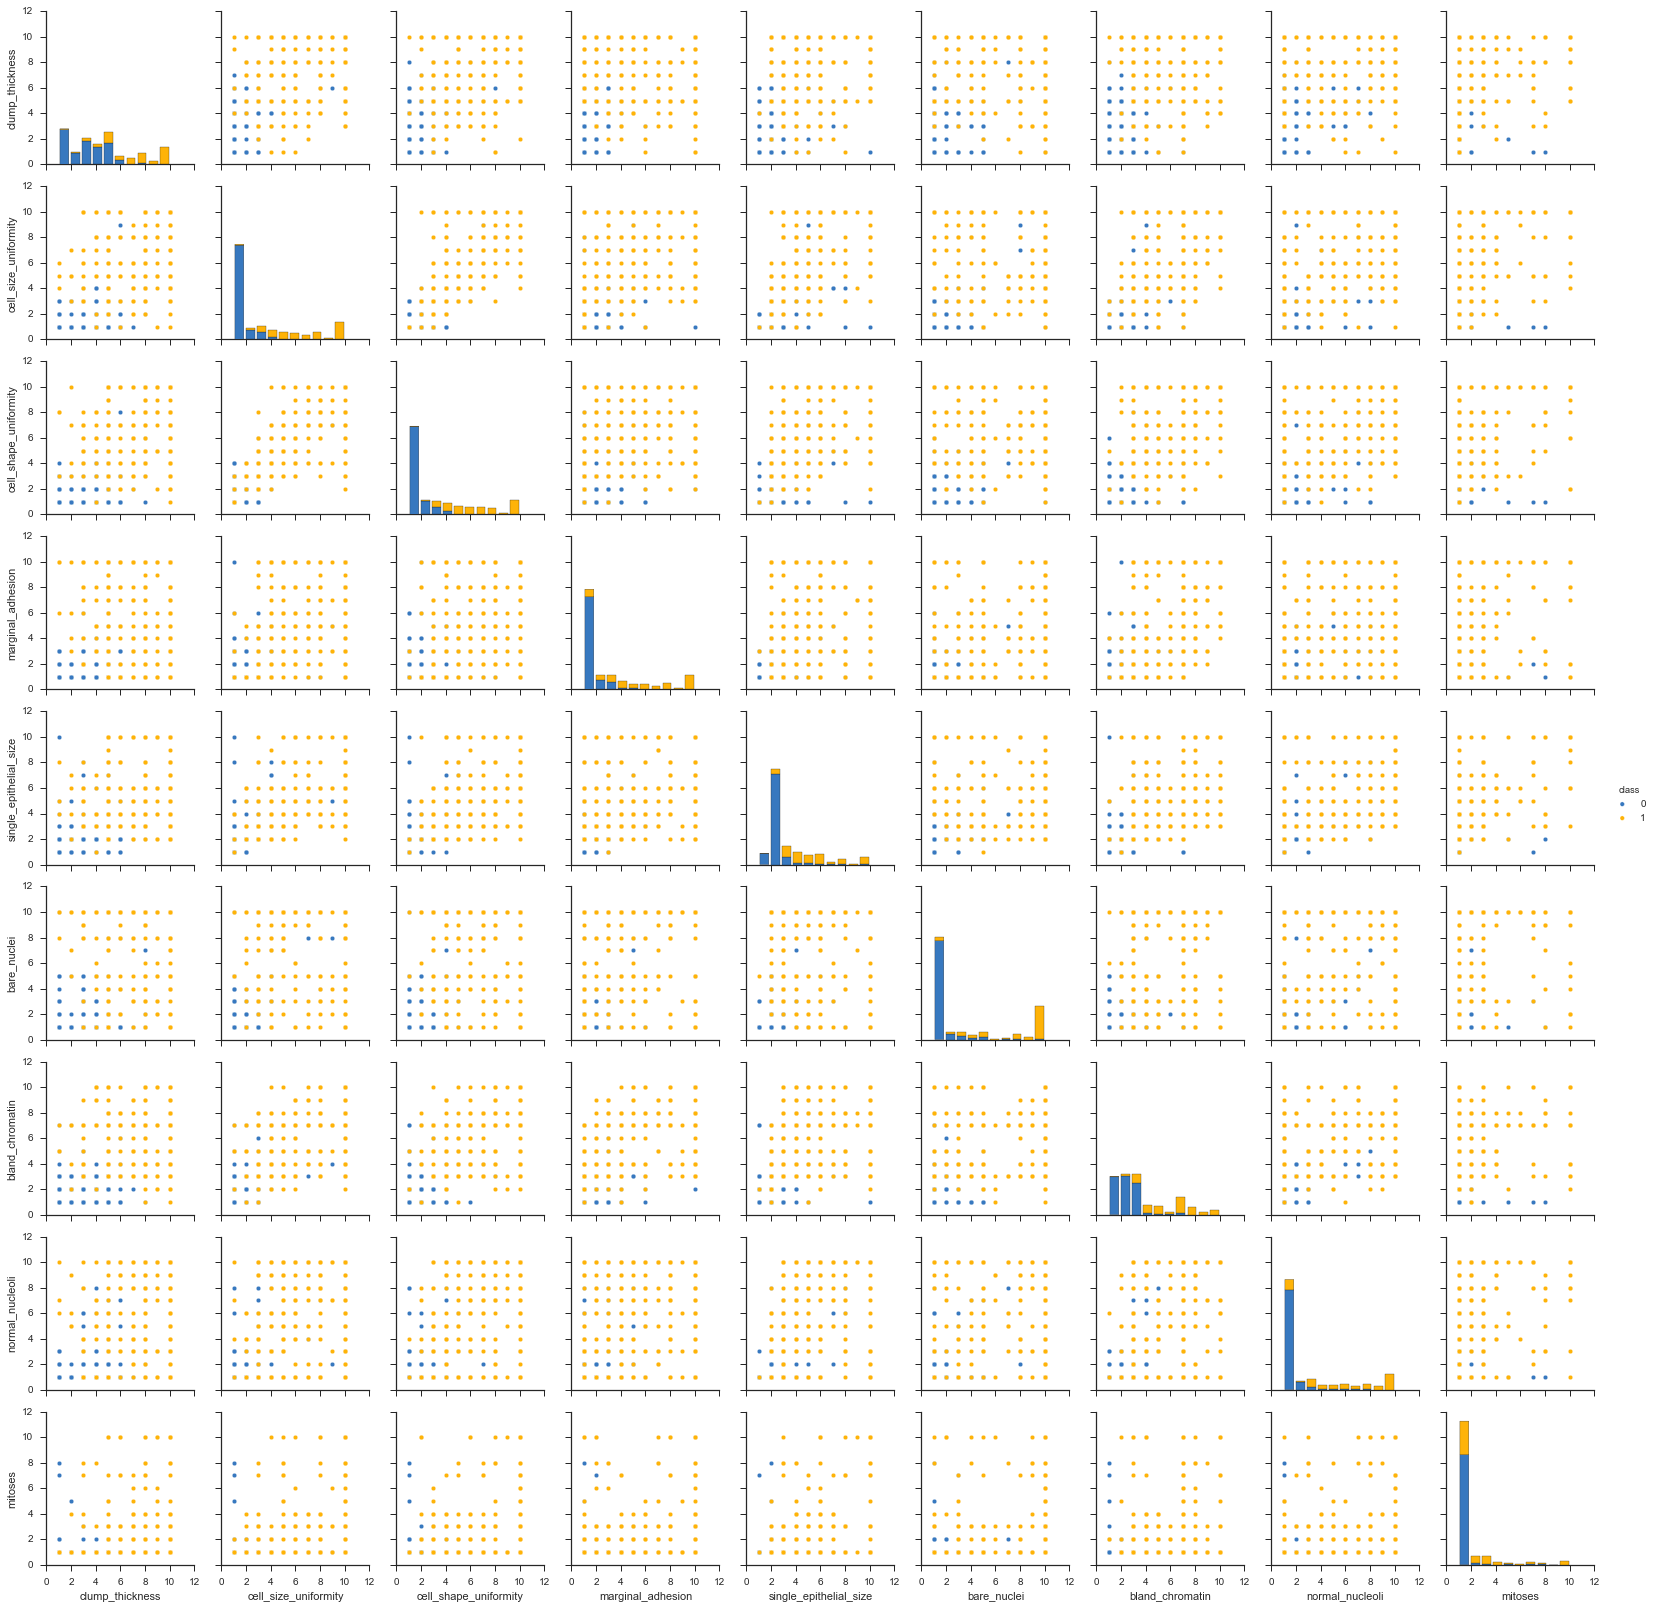

In [14]:
sns.set(style="ticks", color_codes=True)
var_pairs = sns.pairplot(breast_cancer_data_plot, vars=[x for x in breast_cancer_data_plot if x != 'class'], 
                         hue="class", palette=sns.xkcd_palette(['windows blue', 'amber']))

Let's see how the kNN classifier performs on the dataset (using cross-validation).

We are going to set some parameters in the classifier constructor. Some clarification below:

1. **n_neighbors** specifies how many neighbors will vote on the class
2. **weights** uniform weights indicate that all neighbors have the same weight
3. **metric** and **p** when distance is minkowski (the default) and p == 2 (the default), this is equivalent to the euclidean distance metric

Also load scikit's handy cross-validation module and perform the crossval

In [18]:
knn = KNeighborsClassifier(n_neighbors=5,
                           weights='uniform',
                           p=2,
                           metric='minkowski')

Y = breast_cancer_data['class'].values # The target variable: 1 = malignant, 0 = benign

#  Build the feature matrix of all columns to use to predict whether or not the cell is malignant
X = breast_cancer_data[[x for x in column_names if x not in ['id', 'class']]].values

In [22]:
from sklearn.cross_validation import cross_val_score

# Use cross-valdiation to evaluate the accuracy of the model
# Accuracy here is the performance metric we want to improve, the % of instances correctly classified

accuracies = cross_val_score(knn, X, Y, cv=5)

print("K-Fold accuracies:", accuracies)
print("Mean accuracy:", accuracies.mean())

K-Fold accuracies: [ 0.93430657  0.94890511  0.98540146  0.99270073  0.97777778]
Mean accuracy: 0.967818329278


- As you can see the accuracy is very high with 5 neighbors. [NOTE: ask what might be wrong with accuracy as a metric here].

- Let's see what it's like when we use only 1 neighbor:

In [24]:
knn_n1 = KNeighborsClassifier(n_neighbors=1,
                              weights='uniform',
                              p=2,
                              metric='minkowski')

accuracies = cross_val_score(knn_n1, X, Y, cv=5)

print("K-Fold accuracies:", accuracies)
print("Mean accuracy:", accuracies.mean())

K-Fold accuracies: [ 0.89781022  0.94160584  0.95620438  0.97810219  0.98518519]
Mean accuracy: 0.951781562584


- Even with 1 neighbor we do quite well at predicting the malignant observations.

- Now fit a kNN classifier with n_neighbors=5 using just 'clump thickness' and 'cell size uniformity' as variables.

- Plot the points and the colors of where the classifier decides between malignant vs. benign. The size of the circles denotes the number of observations at that point. The hue of the circle denotes the mixture of class labels between 0 and 1.

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


(0, 12)

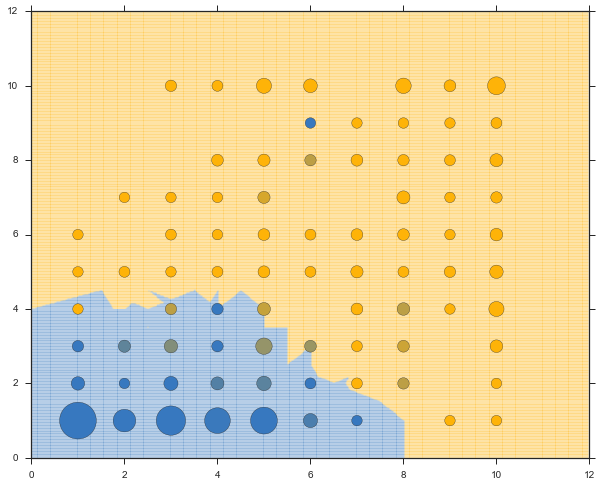

In [110]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.cm as cm
import matplotlib.colors as cl


# reset the colors according to the outcome:
colors = sns.xkcd_palette(['windows blue', 'amber'])

colormap = ListedColormap([colors[0], colors[1]])
cont_cmap = LinearSegmentedColormap.from_list('cont_cmap', colors = [colors[0], colors[1]], N = 1000)

# fit a knn on just two of the predictors with 3 neighbors:
knn_2var = KNeighborsClassifier(n_neighbors=5)
knn_2var.fit(bcw[['clump_thickness','cell_size_uniformity']].values, bcw[['class']].values)

# predict on a grid of points for visualization (lifted from scikit example on this):
x_min, x_max = 0, 12
y_min, y_max = 0, 12
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = knn_2var.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

clump_thickness = bcw[['clump_thickness']].values
cell_size_uni = bcw[['cell_size_uniformity']].values
malignant = bcw[['class']].values


df = bcw[['clump_thickness','cell_size_uniformity','class']]
df = df.groupby(['clump_thickness','cell_size_uniformity'])
df_agg = df.agg([len, np.mean]).reset_index()


clump_agg = df_agg.clump_thickness.values
cell_agg = df_agg.cell_size_uniformity.values
point_means = df_agg['class']['mean'].values
point_sizes = 10+df_agg['class']['len'].values



plt.figure(figsize=[10,8])
plt.pcolormesh(xx, yy, Z, cmap=colormap, alpha=0.1)

# Plot also the training points
plt.scatter(clump_agg, cell_agg, c=point_means, cmap=cont_cmap, s=10*point_sizes)
plt.xlim(0, 12)
plt.ylim(0, 12)
